## Template Matching Proof-of-Concept
#### Author: Christian Grech (MXL, DESY)

### Introduction

<p> The following image shows the SASE 2 beamline at the European XFEL, set up for Hard Xray Self Seeding (HXRSS). In an undulator, alternating magnetic field causes the emission of Xray radiation from electrons. Crystals are then used to filter certain wavelengths/energies. Two crystals can be used but mostly at the EuXFEL, crystal 2 is used. The label for crystal 1 is XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2 and the label for crystal 2 is XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2. The crystals filter out certain photon energies and transmit only particular reflections. We give these reflections an identifier [h,k,l] where h and k and l are integers and this number specifies the direction and plane that the reflection is hitting the crystal. For example for this experiment we frequently use reflections [0,0,4] and [2,2,0].

![Undulator](images/und3.png)

<p> We have available a precise model which can predict the reflections according to how the crystal is positioned. The parameters hmax, kmax, lmax, dthp, dthy, dthr, alpha are normally unchanged. The roll angle depends on the roll of the crystal and the last three parameters are min_pitch, max_pitch and the number of points. Try experimenting with the model below. </p>


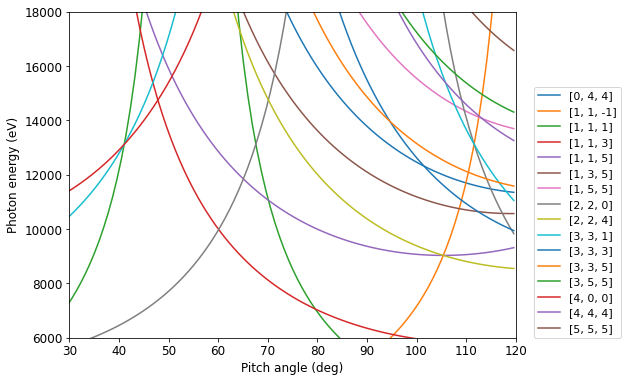

In [71]:
from functions.HXRSS_tool_plotter_limit import Bragg_plotter_limit  # Crystal model 
import matplotlib.pyplot as plt

# Model parameters, these should remain unchanged unless the photon energy is above 15 keV where hmax = 6, kmax = 6, lmax = 7.
hmax = 5
kmax = 5
lmax = 5
dthp = -0.392
dthy = 1.192
dthr = -0.1675
alpha = 0.00238
roll_angle = 1.0869

phen_list, p_angle_list, gid_list, linestyle_list, color_list = Bragg_plotter_limit(hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle, 30, 120, 100)


plt.figure(figsize=(8,6),facecolor='white')

#plt.plot(x, y)
gidlegend = ['[0, 4, 4]', '[1, 1, 1]', '[1, 1, -1]', '[1, 1, 3]', '[1, 1, 5]', '[1, 3, 5]', '[1, 5, 5]', '[2, 2, 0]', '[2, 2, 4]', '[3, 3, 1]', '[3, 3, 3]', '[3, 3, 5]', '[3, 5, 5]', '[4, 0, 0]', '[4, 4, 4]', '[5, 5, 5]']

for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
    if gid in gidlegend:
        plt.plot(pangle, phen, label=gid) # I am only plotting a few reflections here but there are many more

plt.xlabel("Pitch angle (deg)")
plt.ylabel("Photon energy (eV)")
plt.rcParams.update({'font.size': 11})
plt.ylim(6000, 18000) # This is the range of energies we are interested in
plt.xlim(30, 120)
plt.legend(loc=(1.04,0))
#plt.title("Crystal Reflection Model")
plt.show()

### Spectrometer images

<p>A spectrometer is an instrument used to measure and record the emitted beam's spectral information. Thanks to a spectrometer at the end of the output undulator, we are able to measure the energy at different crystal pitch angles. This results in images as shown in figure 1 below, which are saved as npz files. The lines are the reflections similar to those shown in the model above. The issue with these image is that the y-axis (photon energy) is not always correct, as a random vertical offset is present everytime we use the instrument. We would like to compare these image with the model as shown in the second image below and find this energy difference.

<ipython-input-75-05d7c1823434>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(doocs_scale, phen_scale+120, orig_image, cmap='viridis', shading='auto')


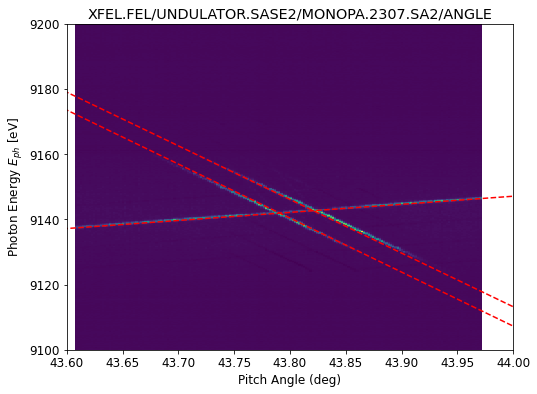

In [75]:
import numpy as np

# Load the spectrometer image
filepath = r'sampledata.nosync/20200927-21_08_12_cor2d.npz' 
tt = np.load(filepath)
corr2d = tt['corr2d']
orig_image = tt['corr2d'].T
spec_hist = tt['spec_hist']
doocs_scale = tt['doocs_scale']
phen_scale = tt['phen_scale']
doocs_label = tt['doocs_channel']


# Plot the spectrometer image
plt.figure(figsize=(8,6),facecolor='white')
plt.rcParams.update({'font.size': 12})

plt.pcolormesh(doocs_scale, phen_scale+120, orig_image, cmap='viridis', shading='auto')
plt.title(doocs_label)

plt.xlabel('Pitch Angle (deg)')
plt.ylabel(r'Photon Energy $E_{ph}$ [eV]')
#plt.ylim(13090, 13150) # This is the range of energies we are interested in
#plt.show()

# Plot the model
#plt.figure(figsize=(8,6),facecolor='white')
for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
    plt.plot(pangle, phen, label=gid, linestyle='dashed', color='red') # I am only plotting a few reflections here but there are many more

#plt.xlabel("Pitch angle (deg)")
#plt.ylabel("Photon energy (eV)")
plt.ylim(9100, 9200) # This is the range of energies we are interested in
plt.xlim(43.6, 44)
#plt.title("Crystal Reflection Model")
plt.show()

### Template matching

<p> The template is the spectrometer scan in npz format (pitch angle versus photon energy). The roll angle is obtained from the corresponding status text file or from the pickle file database where this file is not available. The image is created from the model with the function Bragg_plotter_limit which takes the following inputs: hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle, minimum pitch value, max pitch value, number of points. The outputs are the photon energy values, pitch angle values, reflection id, linestyle and color.</p>

In [45]:
from functions.HXRSS_tool_plotter_limit import Bragg_plotter_limit  # Crystal model 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import re
import time
from datetime import datetime, timezone
import pytz
import matplotlib.colors as colors

from skimage import data
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import match_template
from skimage.filters import threshold_yen

### Input settings

In [122]:
directory = r'sampledata.nosync/'           # This is the folder with the images and corresponding status files
readfromdb = "database/op_20220607.pkl"     # This is a dataframe with past calibration values and roll angle information for images with no status file
df_db = pd.read_pickle(readfromdb)

m=0
# Model parameters, these should remain unchanged unless the photon energy is above 15 keV where hmax = 6, kmax = 6, lmax = 7.
hmax = 5
kmax = 5
lmax = 5
dthp = -0.392
dthy = 1.192
dthr = -0.1675
alpha = 0.00238

### Functions

In [124]:
# this function is used to get the roll angle from the pickle database based on the nearest available date
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

### Iterate through images and perform matching


Monochromator 2 image found; from database: roll angle=1.0869 deg 

20200927-21_07_47_cor2d.npz
Original measured point 9009.32 eV
Matched model point 9128.61 eV
Template Matching Calibration 119.29 eV
Estimated Calibration (by visual inspection) 120.0 eV 



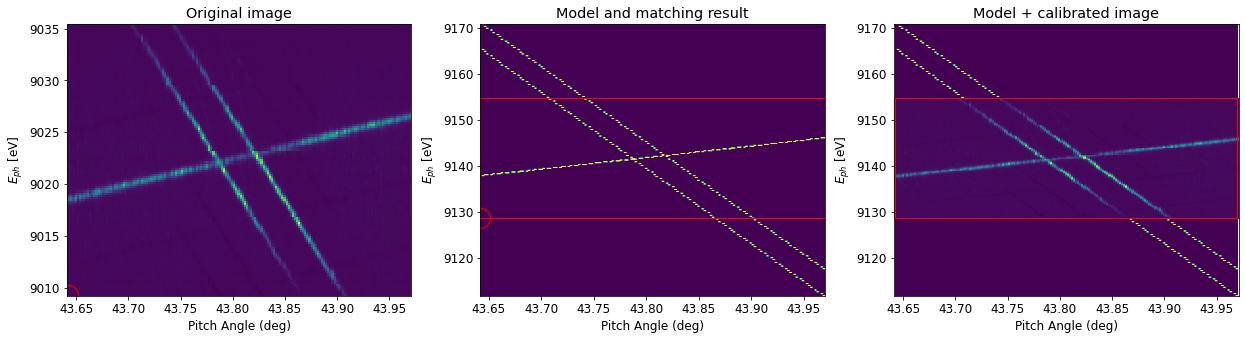

Monochromator 2 image found; from database: roll angle=1.4284 deg 

20201004-10_31_43_cor2d.npz
Original measured point 9002.1 eV
Matched model point 9084.2 eV
Template Matching Calibration 82.1 eV
Estimated Calibration (by visual inspection) 83.0 eV 



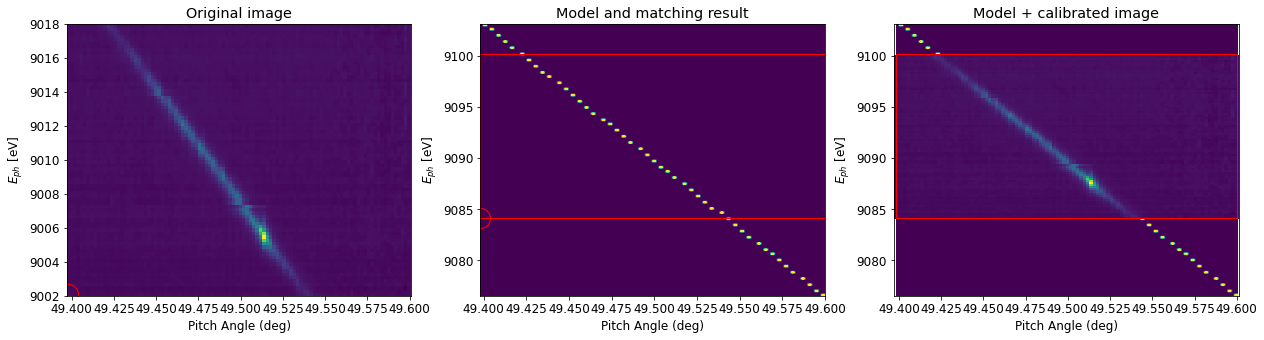

Monochromator 2 image found; from database: roll angle=1.4284 deg 

20201004-13_09_14_cor2d.npz
Original measured point 9005.1 eV
Matched model point 9088.24 eV
Template Matching Calibration 83.14 eV
Estimated Calibration (by visual inspection) 83.0 eV 



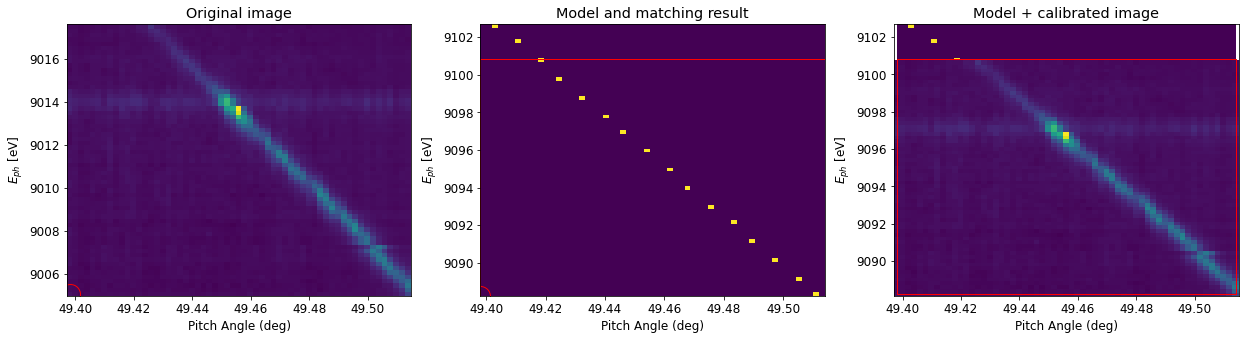

Monochromator 2 image found; from database: roll angle=1.4284 deg 

20201022-06_22_52_cor2d.npz
Original measured point 8962.27 eV
Matched model point 9143.81 eV
Template Matching Calibration 181.55 eV
Estimated Calibration (by visual inspection) 177.0 eV 



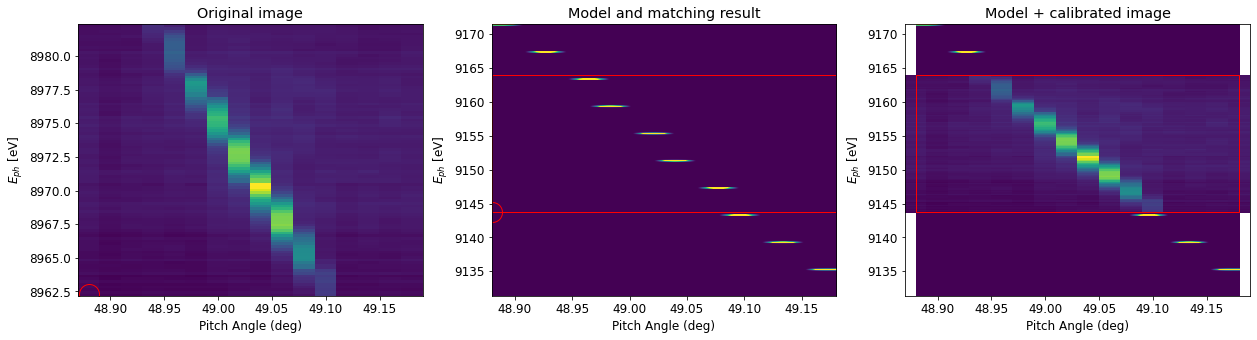

Monochromator 2 image found; from database: roll angle=1.438 deg 

20201118-20_50_56_cor2d.npz
Original measured point 12905.47 eV
Matched model point 13098.96 eV
Template Matching Calibration 193.49 eV
Estimated Calibration (by visual inspection) 201.0 eV 



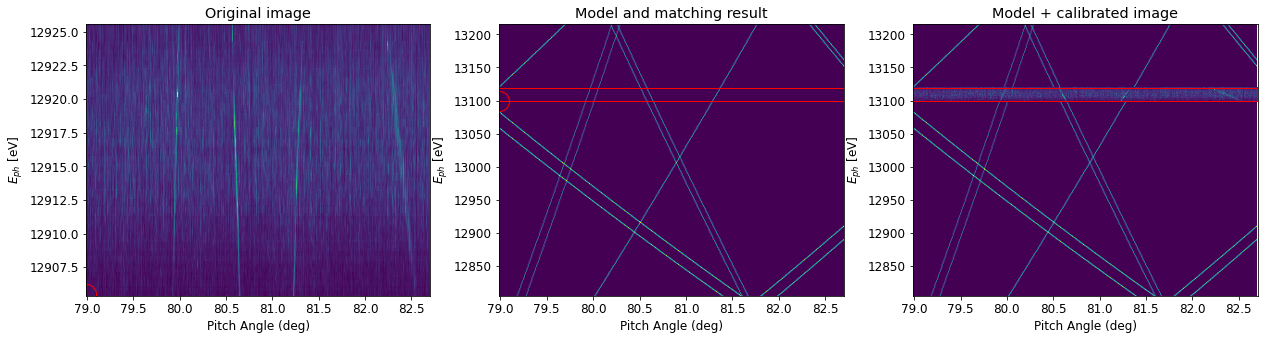

Monochromator 2 image found; from database: roll angle=1.438 deg 

20201119-02_59_18_cor2d.npz
Original measured point 13078.67 eV
Matched model point 13154.4 eV
Template Matching Calibration 75.74 eV
Estimated Calibration (by visual inspection) 201.0 eV 



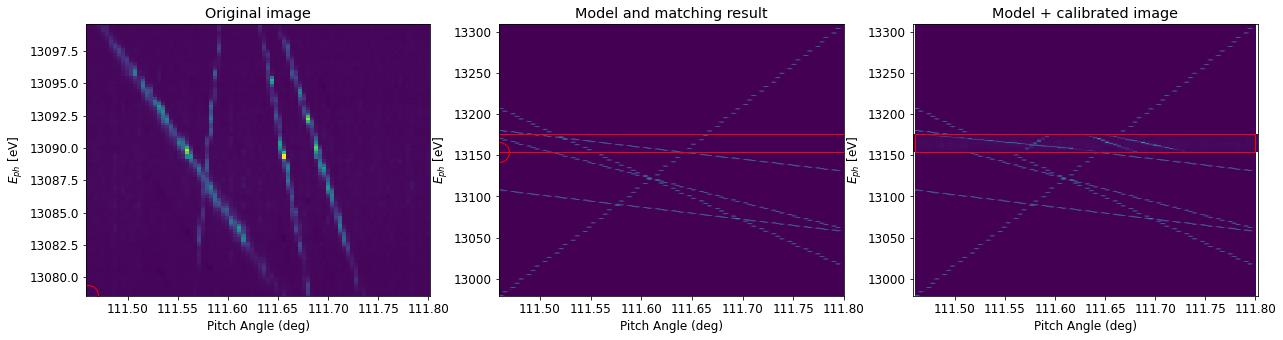

Monochromator 2 image found; from database: roll angle=1.438 deg 

20201119-03_03_27_cor2d.npz
Original measured point 13083.07 eV
Matched model point 13086.44 eV
Template Matching Calibration 3.37 eV
Estimated Calibration (by visual inspection) 201.0 eV 



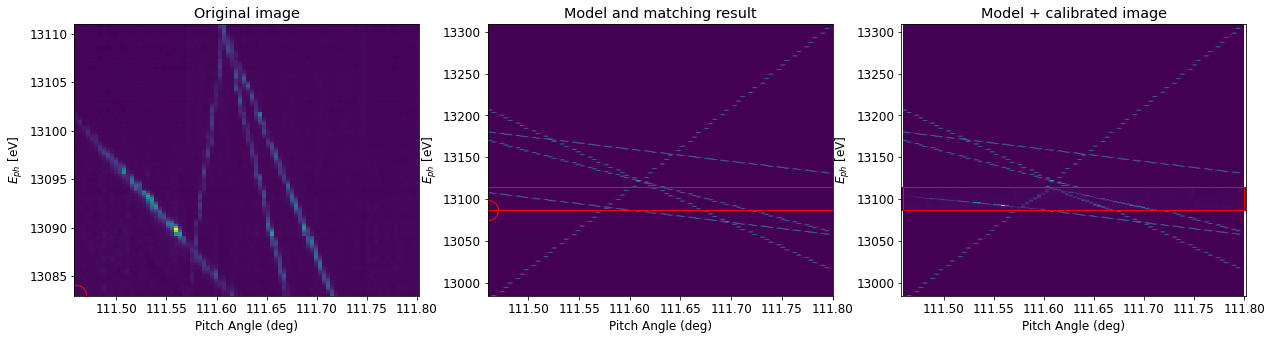

Monochromator 2 image found; from database: roll angle=1.438 deg 

20201119-03_20_19_cor2d.npz
Original measured point 13104.68 eV
Matched model point 13103.04 eV
Template Matching Calibration -1.64 eV
Estimated Calibration (by visual inspection) 201.0 eV 



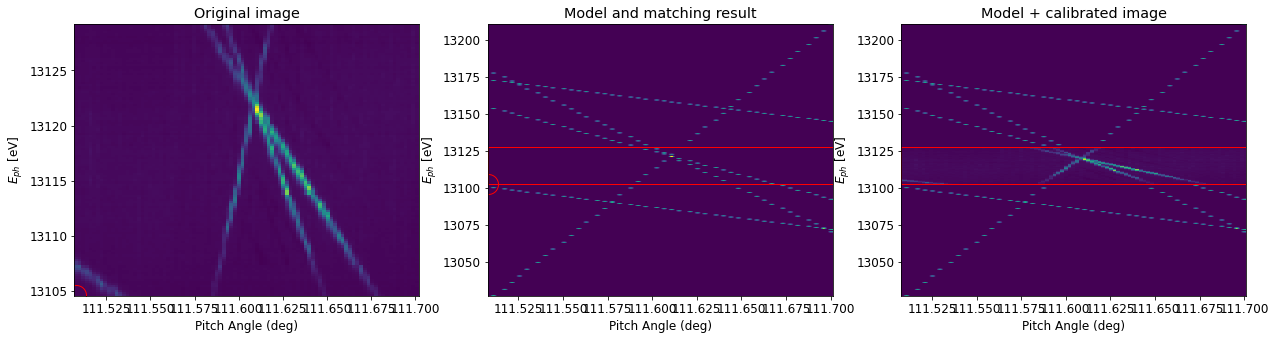

Monochromator 2 image found; from database: roll angle=1.45 deg 

20201119-21_41_05_cor2d.npz
Original measured point 13085.21 eV
Matched model point 13093.3 eV
Template Matching Calibration 8.09 eV
Estimated Calibration (by visual inspection) 201.0 eV 



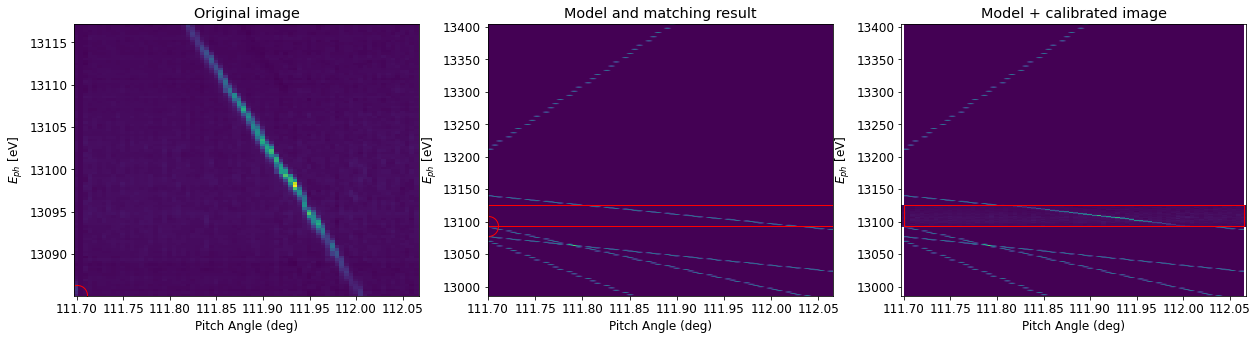

Monochromator 2 image found; from database: roll angle=1.45 deg 

20201120-03_24_28_cor2d.npz
Original measured point 13103.22 eV
Matched model point 13084.23 eV
Template Matching Calibration -18.99 eV
Estimated Calibration (by visual inspection) 201.0 eV 



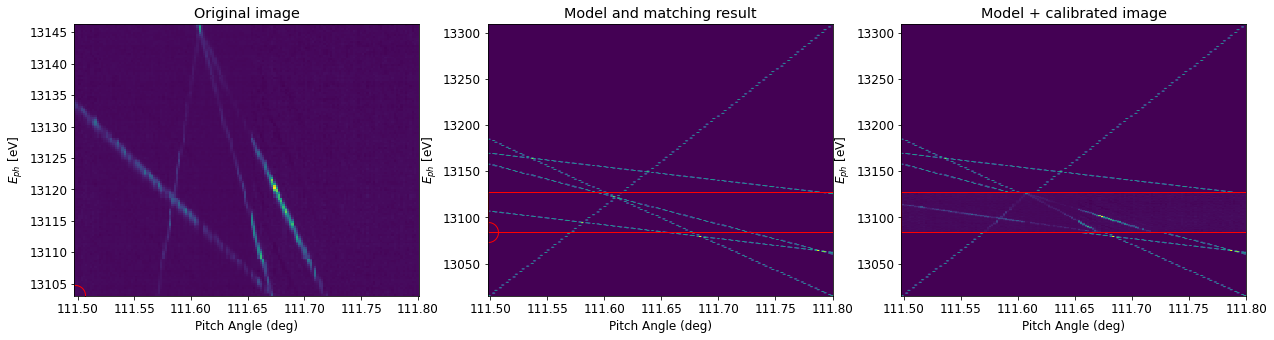

Monochromator 2 image found; from database: roll angle=1.07 deg 



In [ ]:
for filename in sorted(os.listdir(directory)):
    if filename.endswith(".npz"):
        filepath=os.path.join(directory, filename)
        tt = np.load(filepath)
        corr2d = tt['corr2d']
        orig_image = tt['corr2d']
        spec_hist = tt['spec_hist']
        doocs_scale = tt['doocs_scale'] 
        phen_scale = tt['phen_scale']
        doocs_label = tt['doocs_channel']
        # check if the image corresponds to a crystal pitch angle scan. MONOPA 
        if "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2/ANGLE" in doocs_label or "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2/ANGLE" in doocs_label:
            date_raw=filename[ 0 : 17 ]
            date_time_obj = datetime.strptime(date_raw, '%Y%m%d-%H_%M_%S') #strip date from image filename
            m=m+1
            # Search for corresponding roll angle from the status file or the database pickle file.
            if "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2/ANGLE" in doocs_label: 
                mono_no_pitch = 1
                try:
                    filedata = np.loadtxt(
                        filepath+'_status.txt', dtype='str', delimiter=',', skiprows=1)
                    ra_pos = np.where(
                        filedata == 'XFEL.FEL/UNDULATOR.SASE2/MONORA.2252.SA2/ANGLE')
                    ra_row = ra_pos[0][0]
                    roll_angle = float(filedata[ra_row][1])
                    print('Monochromator 1 image found; \nMachine status file found: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                except:
                    try:
                        berlin = pytz.timezone('Europe/Berlin')
                        df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                        df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                        dt = date_time_obj
                        dt = dt.replace(tzinfo=berlin)
                        roll = df_db['roll_angle'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                        roll_angle = float(roll.iloc[0])
                        print('Monochromator 1 image found; from database: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                    except:
                        roll_angle = 1
                        print('Monochromator 1 image found; Default roll angle set (1 deg).')
            elif "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2/ANGLE" in doocs_label:
                mono_no_pitch = 2
                try:
                    filedata = np.loadtxt(
                        filepath+'_status.txt', dtype='str', delimiter=',', skiprows=1)
                    ra_pos = np.where(
                        filedata == 'XFEL.FEL/UNDULATOR.SASE2/MONORA.2307.SA2/ANGLE')
                    ra_row = ra_pos[0][0]
                    roll_angle = float(filedata[ra_row][1])
                    print('Monochromator 2 image found; \nMachine status file found: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                except:
                    try:
                        berlin = pytz.timezone('Europe/Berlin')
                        df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                        df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                        dt = date_time_obj
                        dt = dt.replace(tzinfo=berlin)
                        roll = df_db['roll_angle'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                        roll_angle = float(roll.iloc[0])
                        print('Monochromator 2 image found; from database: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                    except:
                        roll_angle = 1
                        print('Monochromator 2 image found; Default roll angle set (1 deg).')

            else: 
                mono_no_pitch = 0    
                
            if len(doocs_scale) != len(corr2d):
                np_doocs=doocs_scale[:-1]
            else:
                np_doocs=doocs_scale
            np_phen=phen_scale
            # Calculate energy and pitch angle resolutions
            phen_res=np_phen[2]-np_phen[1]
            angle_res_p=np_doocs[2]-np_doocs[1]
            
            # Threshold the image so that the image can be clipped
            orig_image=orig_image.T
            corr2d[corr2d < 0] = 0  # all values below 0 threshold are set to 0
            thresh = threshold_yen(orig_image, nbins=256)
            binary = orig_image > thresh
            processed_image = binary
           
            
            # Filter out the pixels labelled '0' and keep the pixels labelled '1' and create a dataframe
            df = pd.DataFrame(data=processed_image.T).astype(int)  # Convert image values from BOOL to INT
            df_scale = pd.DataFrame(data=np_doocs)
            df_scale.columns = ['parameter']
            df_phen = pd.DataFrame(data=np_phen)
            df_phen.columns = ['value']
            df_phen = df_phen.T
            df = pd.concat([df, df_phen])
            df.columns = df.iloc[-1]
            df.drop(df.tail(1).index,inplace=True)
            df=df.join(df_scale, lsuffix='caller', rsuffix='other')
            df.set_index('parameter', inplace=True)
            df1 = df.stack().reset_index()
            #set column names
            df1.columns = ['Parameter','Energy','Correlation']
            df2 = df1[df1['Correlation'] != False]
            df2=df2.drop(columns=['Correlation'])
            
            # Min and max energies after clipping
            min_phen = min(df2['Energy'])
            max_phen = max(df2['Energy'])
            
            #print(min_phen, max_phen)
            # Create a mask with these two energies so that the image can be clipped
            mask = (np_phen > min_phen) & (np_phen < max_phen)
 
            # making new array based on mask
            phen_clipped = np_phen[mask]
            
            #### MODEL image generation
            phen_list, p_angle_list, gid_list, linestyle_list, color_list = Bragg_plotter_limit(hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle, min(doocs_scale)-1, max(doocs_scale)+1, len(np_doocs)*5)
            ph_axis, pa_axis = [], []
            for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
                for ph_value, pa_value in zip(phen, pangle):
                    # Only keep photon energies within a close range of the spectrometer image range
                    if ph_value > min_phen-100 and ph_value < max_phen+290 and pa_value >= min(doocs_scale) and pa_value <= max(doocs_scale):
                        ph_axis.append(ph_value)
                        pa_axis.append(pa_value)
            
            # Create arrays
            x = np.array(pa_axis)
            y = np.array(ph_axis)
            ph_range = abs(min(ph_axis)-max(ph_axis))
            # calculate how many pixels are required for the model image so that each pixel has the same resolution as the spectrometer image
            phbins = int(ph_range/phen_res)
            
            heatmap, xedges, yedges = np.histogram2d(x, y, bins=[len(np_doocs), phbins], range=[[min(np_doocs), max(np_doocs)], [min(ph_axis), max(ph_axis)]])
            extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
            model_phres = abs(yedges[0]-yedges[1])
            model_pares = abs(xedges[0]-xedges[1])
            model_phrange = abs(yedges[0]-yedges[-1])
            model_parange = abs(xedges[0]-xedges[-1])
            meas_phrange = abs(phen_clipped[0]-phen_clipped[-1])
            meas_parange = abs(np_doocs[0]-np_doocs[-1])
            
            
            fig, (ax, ax1, ax4) = plt.subplots(1, 3, figsize=(21, 5))
            #fig.suptitle(filename, fontsize=11)

            #plot = ax0.pcolormesh(np_doocs, np_phen, orig_image, cmap='viridis', shading='auto')
            #ax0.set_title('Original image')
            #ax0.set_xlabel('Pitch Angle (deg)')
            #ax0.set_ylabel(r'$E_{ph}$ [eV]')
                
            plot = ax.pcolormesh(np_doocs, phen_clipped, orig_image[mask], cmap='viridis', shading='auto')
            ax.plot(np_doocs[0], phen_clipped[0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=20)
            ax.set_title('Original image')
            ax.set_xlabel('Pitch Angle (deg)')
            ax.set_ylabel(r'$E_{ph}$ [eV]')
                
                
            meas = orig_image[mask]
            model = heatmap.T
            
            # Match Template
            try:
                result = match_template(model, meas, pad_input=False)
                ij = np.unravel_index(np.argmax(result), result.shape)
                x, y = ij[::-1]
                #print('Image shape', model.shape)
                #print('Template shape', meas.shape)
                print(filename)
            
                #ax2.pcolormesh(xedges, yedges, heatmap.T, cmap='viridis', shading='auto')
                ax1.imshow(model, extent=extent, origin='lower', aspect='auto', vmin=0., vmax=0.5)
                ax1.set_title('Model and matching result')
                # highlight matched region
                hmeas, wmeas = meas.shape   # Shape of spectrometer image in pixels
                rect = plt.Rectangle((xedges[0]+(model_pares*x), yedges[0]+(model_phres*y)), model_parange, (hmeas*phen_res), edgecolor='r', facecolor='none')
                ax1.plot((x*model_pares)+xedges[0], (y*model_phres)+yedges[0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=20)
                ax1.add_patch(rect)
                ax1.set_xlabel('Pitch Angle (deg)')
                ax1.set_ylabel(r'$E_{ph}$ [eV]')

                #ax3.imshow(result, origin='lower', aspect='auto', interpolation='bilinear')
                #ax3.set_title('`match_template`\nresult')
                # highlight matched region
                #ax3.autoscale(False)
                #ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)


                calibrated_point = yedges[0]+(model_phres*y)
                orig_point = phen_clipped[0]

                print('Original measured point',  np.round(orig_point,2), 'eV')
                print('Matched model point',  np.round(calibrated_point,2), 'eV')
                print('Template Matching Calibration', np.round(calibrated_point-orig_point, 2), 'eV')

                try:
                    date_raw=filename[ 0 : 17 ]
                    date_time_obj = datetime.strptime(date_raw, '%Y%m%d-%H_%M_%S') #strip date from image filename
                    berlin = pytz.timezone('Europe/Berlin')
                    df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                    df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                    dt = date_time_obj
                    dt = dt.replace(tzinfo=berlin)
                    calib_en = df_db['en_cal'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                    en_cal = float(calib_en.iloc[0])
                    print('Estimated Calibration (by visual inspection) ' + str(en_cal) + ' eV \n')
                except:
                    print('No calibration value.')

                ax4.set_title('Model + calibrated image')
                ax4.imshow(model, extent=extent, origin='lower', aspect='auto', vmin=0., vmax=0.5)
                ax4.pcolormesh(np_doocs, phen_clipped+np.round(calibrated_point-orig_point, 2), orig_image[mask], cmap='viridis', shading='auto')
                rect2 = plt.Rectangle((xedges[0]+(model_pares*x), yedges[0]+(model_phres*y)), model_parange, (hmeas*phen_res), edgecolor='r', facecolor='none')
                ax4.add_patch(rect2)
                ax4.set_xlabel('Pitch Angle (deg)')
                ax4.set_ylabel(r'$E_{ph}$ [eV]')
                plt.show()
                
            except:
                print(filename, 'did not work')
                continue

            